# Analysis of the results

This notebook investigates the results of all the model runs in the directory `results/runs`.

## Imports and hardcoded variables

In [1]:
import json
import os

from typing import Optional

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from pprint import pprint
from scipy.special import expit

from src.prepared_data import PreparedData, load_prepared_data

INFERENCES_DIR = "inferences"
ARVIZ_STYLE = "arviz-redish"
DATA_DIR = os.path.join("data", "prepared")

plt.style.use(ARVIZ_STYLE)

# Fetch data

In [2]:
data = {
    d: load_prepared_data(os.path.join(DATA_DIR, d))
    for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
    
}
data["bdb"].measurements.head()

,Unnamed: 0,player_season,season,n_attempt,n_success
0,0,abramcj012022,2022,300,84
1,1,abreujo022017,2017,675,239
2,2,abreujo022018,2018,553,180
3,3,abreujo022019,2019,693,229
4,4,abreujo022020,2020,262,97


# Plot the data

The cell below creates a function for plotting data, then runs it for the 2006 and recent datasets.

I added some lines at 0.2 and 0.4 to illustrate that the recent dataset seems to be a little vertically shifted up compared to the 2006 dataset.

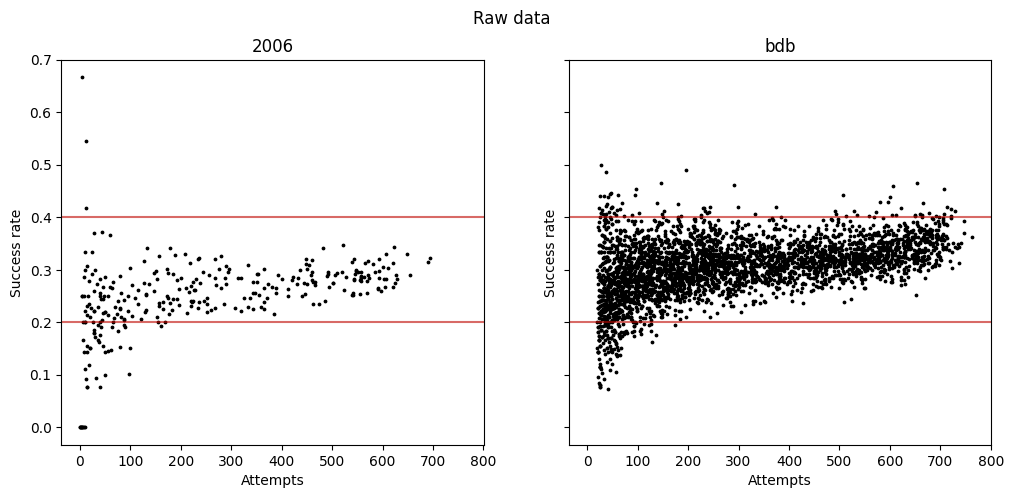

In [3]:
def plot_raw_data(ax: plt.Axes, ppd: PreparedData) -> plt.Axes:
    """Plot raw data on an axis."""
    m = ppd.measurements
    scatter = ax.scatter(m["n_attempt"], m["n_success"] / m["n_attempt"], s=3, color="black", label="observed")
    ax.set(xlabel="Attempts", ylabel="Success rate")
    return ax

f, axes = plt.subplots(1, 2, figsize=[12, 5], sharey=True, sharex=True)
for ax, ppd in zip(axes, data.values()):
    ax = plot_raw_data(ax, ppd)
    for y in [0.2, 0.4]:
        ax.axhline(y, alpha=0.6)
    ax.set_title(ppd.name)
f.suptitle("Raw data")
f.savefig("plots/raw_data.png", bbox_inches="tight")

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [4]:
idatas = {
    d: az.from_json(os.path.join(INFERENCES_DIR, d, "idata.json"))
    for d in os.listdir(INFERENCES_DIR)
    if os.path.isdir(os.path.join(INFERENCES_DIR, d))
}     
idatas["gpareto2006"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [5]:
az.summary(idatas["gpareto2006"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.254,0.126,2.021,2.487,0.001,0.001,16296.0,6495.0,1.0
k,-0.868,0.049,-0.954,-0.772,0.000,0.000,16297.0,6374.0,1.0
alpha[0],-0.904,0.094,-1.079,-0.727,0.001,0.000,19730.0,5366.0,1.0
alpha[1],-0.942,0.097,-1.120,-0.754,0.001,0.001,17233.0,5123.0,1.0
alpha[2],-1.477,0.271,-1.993,-0.978,0.002,0.002,17137.0,4425.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[303],-1.092,0.098,-1.280,-0.917,0.001,0.000,20102.0,5786.0,1.0
alpha[304],-1.285,0.248,-1.762,-0.820,0.002,0.001,18256.0,4551.0,1.0
alpha[305],-0.949,0.098,-1.138,-0.770,0.001,0.000,22545.0,5256.0,1.0
alpha[306],-1.546,0.460,-2.433,-0.736,0.004,0.003,13392.0,3881.0,1.0


In [6]:
az.summary(idatas["gparetobdb"].sample_stats_prior)

/Users/tedgro/Code/bibat/bibat/examples/baseball/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/Code/bibat/bibat/examples/baseball/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lp,-6025.221,188.062,-6350.650,-5691.57,71.153,52.577,7.0,45.0,1.200000e+00
acceptance_rate,0.937,0.078,0.789,1.00,0.002,0.001,2573.0,2058.0,1.000000e+00
step_size,0.058,0.002,0.057,0.06,0.001,0.001,2.0,2.0,7.007070e+15
tree_depth,6.000,0.000,6.000,6.00,0.000,0.000,2000.0,2000.0,NaN
n_steps,63.000,0.000,63.000,63.00,0.000,0.000,2000.0,2000.0,NaN
diverging,0.000,0.000,0.000,0.00,0.000,0.000,2000.0,2000.0,NaN
energy,7708.532,193.581,7357.010,8040.48,71.264,52.529,8.0,44.0,1.190000e+00


In [7]:
az.summary(idatas["gpareto2006"], var_names=["k", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,-0.868,0.049,-0.954,-0.772,0.000,0.000,16297.0,6374.0,1.0
sigma,2.254,0.126,2.021,2.487,0.001,0.001,16296.0,6495.0,1.0


In [8]:
az.summary(idatas["gparetobdb"], var_names=["k", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,-1.201,0.021,-1.241,-1.163,0.0,0.0,17234.0,5789.0,1.0
sigma,3.108,0.054,3.009,3.211,0.0,0.0,17258.0,5788.0,1.0


In [9]:
az.summary(idatas["gparetobdb"].prior, var_names=["k", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,-0.426,0.145,-0.682,-0.171,0.061,0.046,6.0,34.0,1.25
sigma,1.129,0.353,0.530,1.764,0.148,0.110,6.0,43.0,1.25


# Calibrating the prior distribution using push-forward checking

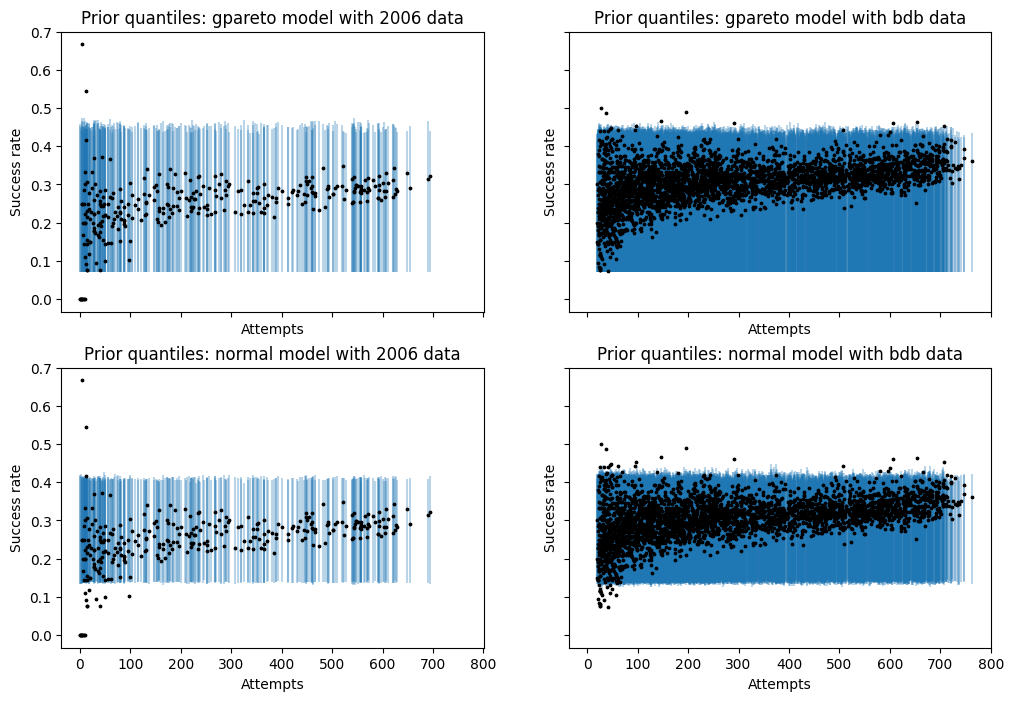

In [13]:
def plot_quantiles(
    ax: plt.Axes, 
    idata_group: xr.Dataset,
    measurements: pd.DataFrame,
    color: str = "tab:blue",
    label: Optional[str] = None
) -> plt.Axes:
    """Plot 1%-99% quantile intervals for the alpha variable on an axis."""
    x = measurements["n_attempt"]
    qs = (
        idata_group["alpha"]
        .quantile([0.01, 0.99], dim=("chain", "draw"))
        .to_series()
        .pipe(expit)
        .unstack("quantile")
    )
    vlines = ax.vlines(
        measurements["n_attempt"], 
        qs[0.01], 
        qs[0.99], 
        zorder=0, 
        color=color, 
        alpha=0.3, 
        label=label
    )
    return ax


f, axes = plt.subplots(2, 2, figsize=[12, 8], sharex=True, sharey=True)

for row, model_prefix in zip(axes, ["gpareto", "normal"]):
    for ax, ppd, idata in zip(
        row, data.values(), [idatas[model_prefix + "2006"], idatas[model_prefix + "bdb"]]
    ):
        ax = plot_raw_data(ax, ppd)
        ax = plot_quantiles(ax, idata.prior, ppd.measurements)
        ax.set_title(f"Prior quantiles: {model_prefix} model with {ppd.name} data")

f.savefig("plots/prior_quantiles.png")

# Comparing modelled and realised success rates

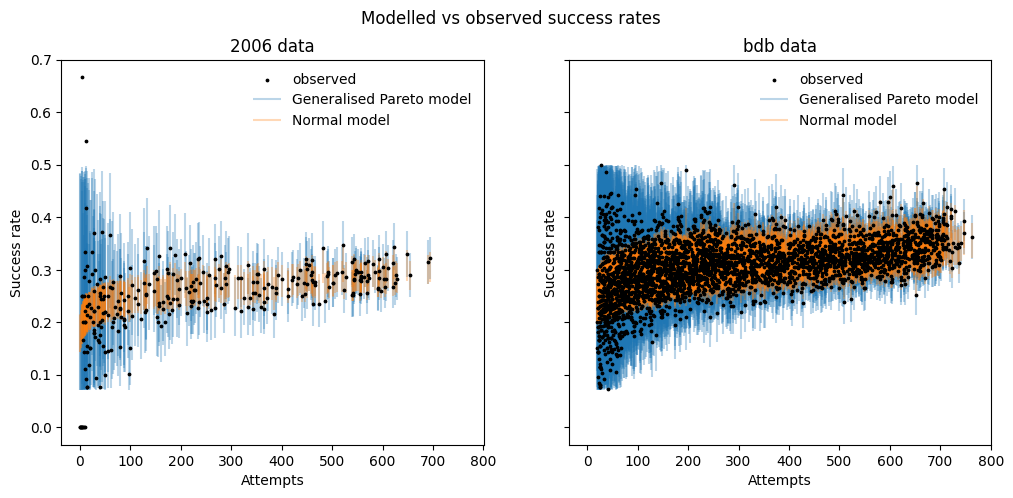

In [11]:
f, axes = plt.subplots(1, 2, figsize=[12, 5], sharex=True, sharey=True)

for ax, ppd, idata_gp, idata_n in zip(axes, data.values(), [idatas["gpareto2006"], idatas["gparetobdb"]], [idatas["normal2006"], idatas["normalbdb"]]):
    ax = plot_raw_data(ax, ppd)
    ax = plot_quantiles(ax, idata_gp.posterior, ppd.measurements, label="Generalised Pareto model")
    ax = plot_quantiles(ax, idata_n.posterior, ppd.measurements, color="tab:orange", label="Normal model")
    leg = ax.legend(frameon=False)
    ax.set_title(f"{ppd.name} data")
f.suptitle("Modelled vs observed success rates")
f.savefig("plots/posterior_quantiles.png")